##     Name: Zeyu Tong

##     Project Name: Signature style recognition


### This project is about signature style recognition based on the OpenCV, Convolutional Neural Network and Tensorflow. Basically, the training dataset is from 4 different people. They produced 18 signatures of different names for training. And 1 signature for testing. Based on the testing result, this signature style recognition system works really well.

In [223]:
import cv2                 
import numpy as np         
import matplotlib.pyplot as plt
import os                  
from random import shuffle 
from tqdm import tqdm      
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

#### Initialize parameter and path  


In [224]:
training_path = 'Training_data'
testing_path = 'Testing_data'
imgSize = 100
Learning_rate = 10**(-3)

In [225]:
def file_name(file_path):   
    L=[]   
    for root, dirs, files in os.walk(file_path):  
        for file in files:  
            if os.path.splitext(file)[1] == '.png':
                file = file.split('.')[-3]
                L.append(file)  
    return L  

In [226]:
name_path = 'Testing_data'
name = file_name(name_path)

#### Conversion to one-hot array

#### This step is to split different styles of signature in the file and convert them to one-hot array

In [227]:
def training_tag(img):
    Name_tag = img.split('.')[-3]
    if Name_tag == 'sg1': return [1,0,0,0]                        
    elif Name_tag == 'sg2': return [0,1,0,0]
    elif Name_tag == 'sg3': return [0,0,1,0]
    elif Name_tag == 'sg4': return [0,0,0,1]

In [228]:
def testing_tag(img):
    Name_tag = img.split('.')[-6]
    if Name_tag == 'style1': return [1,0,0,0]                        
    elif Name_tag == 'style2': return [0,1,0,0]
    elif Name_tag == 'style3': return [0,0,1,0]
    elif Name_tag == 'style4': return [0,0,0,1]

#### Create training and testing data

#### Basically, this process is just read the image from the file. Then, resize the image and save the result

#### tqdm is a nice pretty percentage bar for tasks

In [229]:
def Training_data():
    training_data = []
    for img in tqdm(os.listdir(training_path)[1:]):
        tag = training_tag(img)
        path = os.path.join(training_path,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (imgSize,imgSize))
        training_data.append([np.array(img),np.array(tag)])
    shuffle(training_data)
    return training_data

In [230]:
def Testing_data():
    testing_data = []
    for img in tqdm(os.listdir(testing_path)[1:]):
        path = os.path.join(testing_path,img)
        num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (imgSize,imgSize))
        testing_data.append([np.array(img), num])       
    shuffle(testing_data)
    return testing_data

#### Training Process

In [231]:
train_data = Training_data()

100%|██████████| 72/72 [00:00<00:00, 2156.72it/s]


In [232]:
tf.reset_default_graph()

#### Convolutional Neural Network Structure

In [233]:
CNN = input_data(shape=[None, imgSize, imgSize, 1], name='input')

CNN = conv_2d(CNN, 32, 5, activation='relu')
CNN = max_pool_2d(CNN, 5)

CNN = conv_2d(CNN, 64, 5, activation='relu')
CNN = max_pool_2d(CNN, 5)

CNN = conv_2d(CNN, 32, 5, activation='relu')
CNN = max_pool_2d(CNN, 5)

CNN = conv_2d(CNN, 64, 5, activation='relu')
CNN = max_pool_2d(CNN, 5)

CNN = conv_2d(CNN, 64, 5, activation='relu')
CNN = max_pool_2d(CNN, 5)

CNN = conv_2d(CNN, 128, 5, activation='relu')
CNN = max_pool_2d(CNN, 5)

CNN = fully_connected(CNN, 1024, activation='relu')
CNN = dropout(CNN, 0.8)

CNN = fully_connected(CNN, 4, activation='softmax')
CNN = regression(CNN, optimizer='adam', learning_rate=Learning_rate, loss='categorical_crossentropy', name='output')

Training_model = tflearn.DNN(CNN)

In [234]:
Training = train_data[:]
Testing = train_data[:]

In [235]:
X = np.array([i[0] for i in Training]).reshape(-1,imgSize,imgSize,1)
Y = np.array([i[1] for i in Training])

Test_X = np.array([i[0] for i in Testing]).reshape(-1,imgSize,imgSize,1)
Test_Y = np.array([i[1] for i in Testing])

#### Training 

In [236]:
Training_model.fit({'input': X}, {'output': Y}, n_epoch=100, validation_set=({'input': Test_X}, {'output': Test_Y}))

Training Step: 199  | total loss: 0.44683 | time: 0.383s
| Adam | epoch: 100 | loss: 0.44683 -- iter: 64/72
Training Step: 200  | total loss: 0.40750 | time: 1.452s
| Adam | epoch: 100 | loss: 0.40750 | val_loss: 0.01353 -- iter: 72/72
--


#### Plot the result for the testing

100%|██████████| 4/4 [00:00<00:00, 1318.76it/s]

[  1.77239817e-05   5.40394743e-04   9.97728884e-01   1.71305495e-03]
[  9.18609321e-01   7.56898001e-02   3.60297185e-04   5.34062274e-03]
[ 0.04044556  0.95574278  0.0022535   0.00155818]


[  8.54510581e-04   3.22009349e-04   7.48622688e-06   9.98816013e-01]


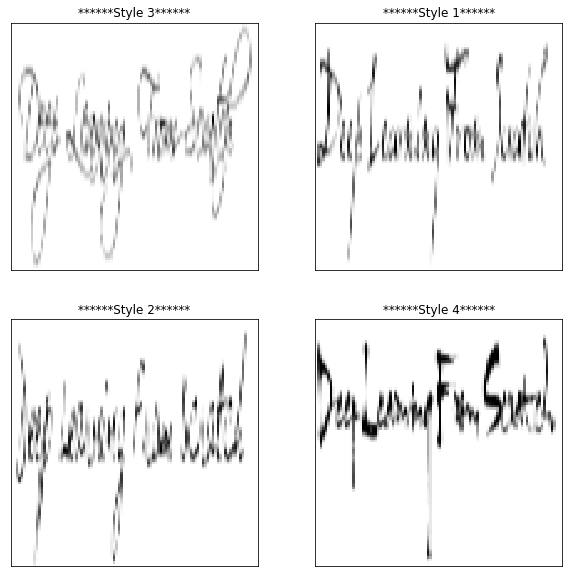

In [237]:
testdata = Testing_data()
fig=plt.figure(figsize=(10, 10))

for seq,dataset in enumerate(testdata[:]):   
    img_seq = dataset[1]
    data = dataset[0]
    sig_fig = fig.add_subplot(2,2,seq+1)
    orig = data
    dataset = data.reshape(imgSize,imgSize,1)
    Training_out = Training_model.predict([dataset])[0]
    print (Training_out)
    a = 0
    for i in range(1,4):
        if Training_out[a] > Training_out[i]:
            label = a
        elif Training_out[a] < Training_out[i]:
            label = i
            a = i
    if label == 0:
        label = '******Style 1******'
    elif label == 1:
        label = '******Style 2******'
    elif label == 2:
        label = '******Style 3******'
    elif label == 3:
        label = '******Style 4******'    
    sig_fig.imshow(orig,cmap='gray')
    plt.title(label)
    sig_fig.axes.get_xaxis().set_visible(False)
    sig_fig.axes.get_yaxis().set_visible(False) 
plt.show()

#### After I get testing result, the next step is to compare the testing result with the original image. If the style name of the testing result is same with the original image,which means this Neural Network is good enough.

In [238]:
def Comparing_data():
    testing_data = []
    for img in tqdm(os.listdir(testing_path)[1:]):
        path = os.path.join(testing_path,img)
        num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (imgSize,imgSize))
        testing_data.append([np.array(img), num])
    return testing_data

100%|██████████| 4/4 [00:00<00:00, 1156.17it/s]


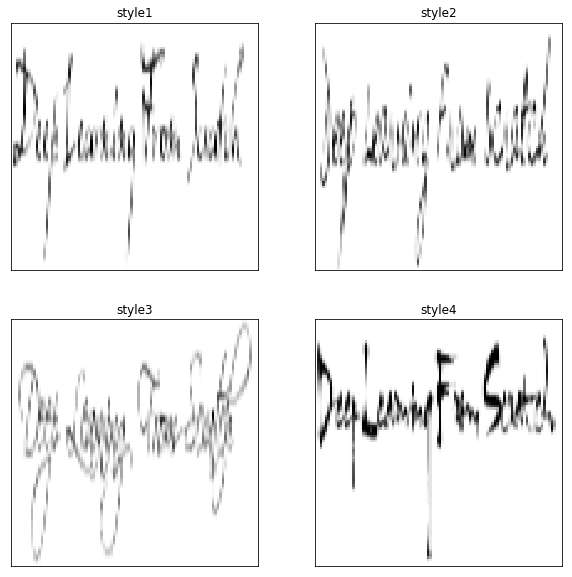

In [239]:
testdata = Comparing_data()
fig=plt.figure(figsize=(10, 10))

for seq,dataset in enumerate(testdata[:]):
    img_seq = dataset[1]
    data = dataset[0]
    sig_fig1 = fig.add_subplot(2,2,seq+1)
    orig = data
    dataset = data.reshape(imgSize,imgSize,1)
    label = name[seq]
    sig_fig1.imshow(orig,cmap='gray')
    plt.title(label)
    sig_fig1.axes.get_xaxis().set_visible(False)
    sig_fig1.axes.get_yaxis().set_visible(False)
plt.show()